<a href="https://colab.research.google.com/github/masterika/Swarmer-detection/blob/master/Swarming_bacteria_detection_with_Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN - swarming Bacillus subtilis






In [1]:
#I.G. Since google colab continuously updates some packages, some functions of Mask-RCNN no longer work
# Therefore, here I'm installing the versions of keras, scipy and tensorflow where code works. 
!pip install keras==2.1.6
!pip install scipy==1.1.0
!pip install tensorflow==1.15
import tensorflow as tf
import keras
import scipy

     |████████████████████████████████| 348kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 31.2MB 105kB/s 
ERROR: umap-learn 0.4.2 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 412.3MB 45kB/s 
     |████████████████████████████████| 3.8MB 25.9MB/s 
     |████████████████████████████████| 512kB 42.9MB/s 
  Created wheel for gast: filename

Using TensorFlow backend.


In [2]:
# I.G. Making sure gpu is enabled on selected version of tensorflow. 
# If not, one should adjust the version as training on CPU is much slower
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# I.G. Making sure all necessary packages are installed
!pip install imgaug
!pip install Cython
!pip install pycocotools
!pip install kaggle

In [4]:
# I.G.Other usefull imports
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd
import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import skimage.draw
import datetime

# I.G. Clonning my github repository where I've uploaded Mask-RCNN core code files.
!git clone https://github.com/masterika/Swarmer-detection.git

import os
# Root directory of the project
ROOT_DIR = os.getcwd()

# importing Mask-RCNN
os.chdir('Swarmer-detection')
from mrcnn import utils 
from mrcnn import config as cf
from mrcnn import model
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Cloning into 'Swarmer-detection'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 137 (delta 5), reused 0 (delta 0), pack-reused 119
Receiving objects: 100% (137/137), 15.16 MiB | 27.67 MiB/s, done.
Resolving deltas: 100% (56/56), done.
... done downloading pretrained model!


In [9]:
# I.G. extract dataset
os.chdir('Datasets')
!unzip bacteria2.zip # Results in creating a folder named "bacteria"
bacteria_dataset_path = os.path.join(os.getcwd(), "bacteria")
os.chdir(ROOT_DIR) # I.G go back to root directory

Archive:  bacteria2.zip
   creating: bacteria/train/
  inflating: bacteria/train/flip_x_train1.jpg  
  inflating: bacteria/train/flip_x_train2.jpg  
  inflating: bacteria/train/flip_x_train3.jpg  
  inflating: bacteria/train/flip_x_train4.jpg  
  inflating: bacteria/train/flip_x_train5.jpg  
  inflating: bacteria/train/flip_x_train6.jpg  
  inflating: bacteria/train/flip_y_train1.jpg  
  inflating: bacteria/train/flip_y_train2.jpg  
  inflating: bacteria/train/flip_y_train3.jpg  
  inflating: bacteria/train/flip_y_train4.jpg  
  inflating: bacteria/train/flip_y_train5.jpg  
  inflating: bacteria/train/flip_y_train6.jpg  
  inflating: bacteria/train/rot_180_train1.jpg  
  inflating: bacteria/train/rot_180_train2.jpg  
  inflating: bacteria/train/rot_180_train3.jpg  
  inflating: bacteria/train/rot_180_train4.jpg  
  inflating: bacteria/train/rot_180_train5.jpg  
  inflating: bacteria/train/rot_180_train6.jpg  
  inflating: bacteria/train/rot_270_train1.jpg  
  inflating: bacteria/train/

## Configurations

In [5]:
class BacteriaConfig(cf.Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "bacteria"
    BACKBONE = "resnet101"
    # I.G. We use a GPU with 12GB memory, which can fit 16 256X256 images but
    # Since I'm not using minimask, even 12 GB memory cannot do more than 1 256X256 image at a time.
    IMAGES_PER_GPU = 1 #
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # I.G. Background + bacteria

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small     
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  
    
    #I.G. 3x default values for the following parameters because number of instances is high
    POST_NMS_ROIS_TRAINING  =       3000
    PRE_NMS_LIMIT           =       18000
    RPN_TRAIN_ANCHORS_PER_IMAGE =   768
    TRAIN_ROIS_PER_IMAGE        =   600
    
    # Number of training steps per epoch    
    STEPS_PER_EPOCH = 200 # I.G. epoch really plays the role of checkpoint here    
    DETECTION_MIN_CONFIDENCE = 0.9 # I.G. default 0.7  
    USE_MINI_MASK = False # I.G. changed from true because the objects are crowded and cannot afford to lose precision of masks
config = BacteriaConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [0]:
class BacteriaDataset(utils.Dataset):
    def load_bacteria(self, dataset_dir, subset):
        """Load a subset of the bacteria dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("bacteria", 1, "swarming_bsub")
        
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            self.add_image(
                "bacteria",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)
          
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bacteria dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "bacteria":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "bacteria":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [0]:
# Training dataset.
dataset_train = BacteriaDataset()
dataset_train.load_bacteria(bacteria_dataset_path, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = BacteriaDataset()
dataset_val.load_bacteria(bacteria_dataset_path, "val")
dataset_val.prepare()

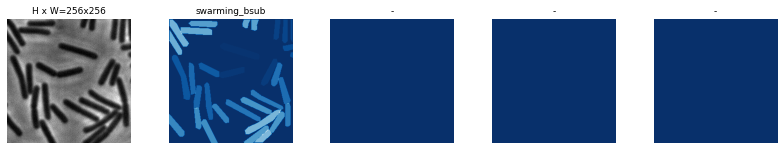

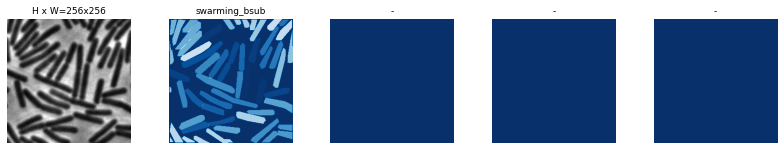

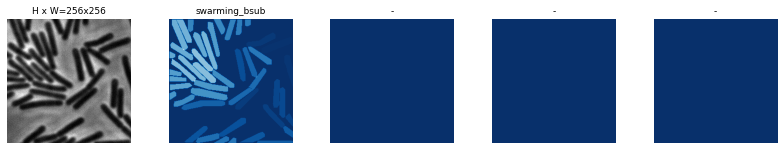

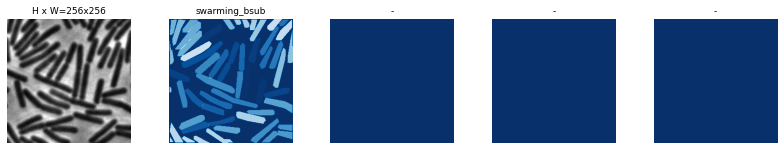

In [109]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [12]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    #model.load_weights(model.find_last()[1], by_name=True)
    #model_path = os.path.join(MODEL_DIR, "mask_rcnn_bacteria.h5")
    model_path = os.path.join(ROOT_DIR, "mask_rcnn_bacteria.h5")
    model.load_weights(model_path, by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [13]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern. mask-rcnn mask-rcnn mask-rcnn mas
#I.G. It should take less than an hour to finish if you are connected to GPU 
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')      


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/bacteria20200511T1924/mask_rcnn_bacteria_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
199/200 [============================>.] - ETA: 1s - loss: 2.4952 - rpn_class_loss: 0.2046 - rpn_bbox_loss: 0.8329 - mrcnn_class_loss: 0.4123 - mrcnn_bbox_loss: 0.5309 - mrcnn_mask_loss: 0.5144

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


200/200 [==============================] - 257s 1s/step - loss: 2.4896 - rpn_class_loss: 0.2040 - rpn_bbox_loss: 0.8312 - mrcnn_class_loss: 0.4113 - mrcnn_bbox_loss: 0.5298 - mrcnn_mask_loss: 0.5133 - val_loss: 1.5844 - val_rpn_class_loss: 0.1001 - val_rpn_bbox_loss: 0.5540 - val_mrcnn_class_loss: 0.2647 - val_mrcnn_bbox_loss: 0.3895 - val_mrcnn_mask_loss: 0.2761

Epoch 2/10
200/200 [==============================] - 223s 1s/step - loss: 1.4207 - rpn_class_loss: 0.0938 - rpn_bbox_loss: 0.4334 - mrcnn_class_loss: 0.2765 - mrcnn_bbox_loss: 0.3258 - mrcnn_mask_loss: 0.2913 - val_loss: 1.3619 - val_rpn_class_loss: 0.0811 - val_rpn_bbox_loss: 0.5231 - val_mrcnn_class_loss: 0.2303 - val_mrcnn_bbox_loss: 0.2985 - val_mrcnn_mask_loss: 0.2288
Epoch 3/10
200/200 [==============================] - 224s 1s/step - loss: 1.1689 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.3522 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.2529 - mrcnn_mask_loss: 0.2512 - val_loss: 1.2368 - val_rpn_class_loss: 0.070

In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
'''model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")'''

In [0]:
# Save weights
# Typically not needed because callbacks save after every epoch
model_path = os.path.join(MODEL_DIR, "mask_rcnn_bacteria.h5")
model.keras_model.save_weights(model_path)

## Detection

In [43]:
class InferenceConfig(BacteriaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1     
    DETECTION_NMS_THRESHOLD = 0.35 # I.G. default 0.3. overlap threshold beyond which an instance counts as one
    RPN_NMS_THRESHOLD       = 0.7 # I.G. default 0.7, same as DETECTION_NMS_THRESHOLD but for rpn
    DETECTION_MIN_CONFIDENCE = 0.8 # I.G. DEFAULT is  0.7   
    POST_NMS_ROIS_INFERENCE = 3000 # I.G. DEFAULT is 1000  
inference_config = InferenceConfig()
inference_config.display()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR) 

# Get path to saved weights
# Either set a specific path or find last trained weights

#model_path = model.find_last()[1]
MODEL_DIR = os.path.join(ROOT_DIR, "logs") # I.G. If you saved the model with last cell, the copy of last epoch result should appear under "logs" with a name mask_rcnn_bacteria.h5". 
INSIDE_DIR = os.path.join(MODEL_DIR, "bacteria20200511T1310") # I.G. Alternatively, you can go to the folder where results after each epoch is saved and load anything from there
model_path = os.path.join(MODEL_DIR, "mask_rcnn_bacteria.h5") 
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.35
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (46,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (46, 4)               min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 46)        min:    0.00000  max:    1.00000  bool


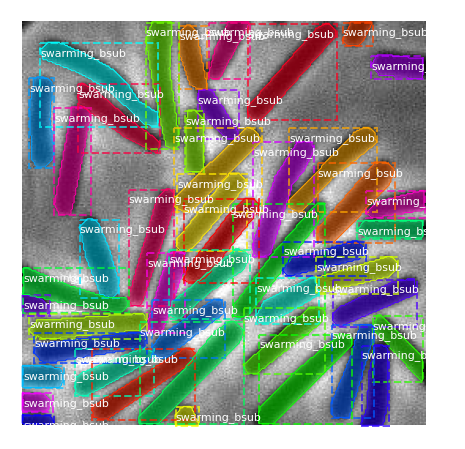

In [46]:
# I.G Display a random image with its annotation
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32


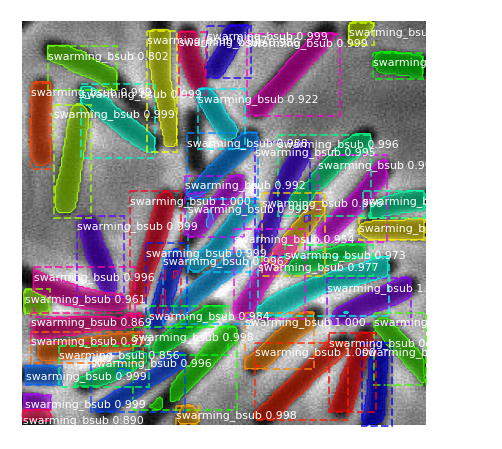

In [47]:
# I.G test how our model performs on that image
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())